# Image Thresholding Techniques
This notebook implements various local thresholding algorithms, including optimal thresholding and Otsu's method. The code includes functions for padding images, computing histograms, and applying thresholding algorithms.


## Import Libraries


In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.optimize import curve_fit
from scipy.stats import norm
import pandas as pd
from sklearn.mixture import GaussianMixture as GMM
import matplotlib as mpl
import warnings 
warnings.filterwarnings("ignore")

## Helper Functions

In [3]:
def _pad_image(kernel_size, grayscale_image):
    """
    Pads the grayscale image with zeros.

    Returns:
        [numpy.ndarray]: A padded grayscale image.
    """
    pad_width = kernel_size // 2
    return np.pad(
        grayscale_image,
        ((pad_width, pad_width), (pad_width, pad_width)),
        mode="edge",
    )

In [4]:
def apply_local_threshold(grayscale_image, threshold_algorithm, kernel_size, n_components=None):
    """
    Applies local thresholding to an image.

    Args:
        grayscale_image: the image to be thresholded
        threshold_algorithm: the algorithm through which local thresholding will be applied.
        kernel_size: the size of the window used in local thresholding

    Returns:
        [numpy ndarray]: the resulted thresholded image after applying the selected thresholding algorithm.
    """
    print('n components:', n_components)
    padded_image = _pad_image(kernel_size, grayscale_image)
    thresholded_image = np.zeros_like(grayscale_image)
    for i in range(grayscale_image.shape[0]):
        for j in range(grayscale_image.shape[1]):
            window = padded_image[i: i + kernel_size, j: j + kernel_size]
            if n_components:
                thresholded_image[i, j] = threshold_algorithm(window, n_components)[kernel_size // 2, kernel_size // 2]
            else:
                thresholded_image[i, j] = threshold_algorithm(window)[kernel_size // 2, kernel_size // 2]
    return thresholded_image

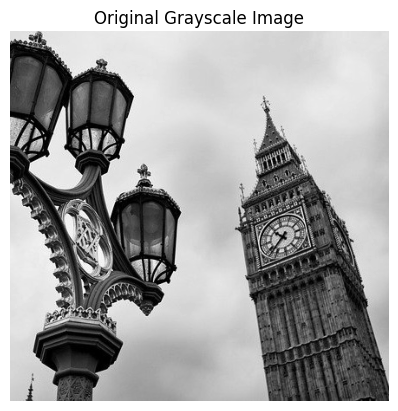

In [10]:
# Load a grayscale image for testing
image_path = '../test_images/elizabeth_tower_london.jpg'  # Replace with your image path
grayscale_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Display the original image
plt.imshow(grayscale_image, cmap='gray')
plt.title('Original Grayscale Image')
plt.axis('off')
plt.show()


## Optimal Thresholding

In [5]:
def optimal_thresholding(image):
    """
    Applies optimal thresholding to an image.

    Args:
        image: the image to be thresholded

    Returns:
        [numpy ndarray]: the resulted thresholded image after applying the optimal thresholding algorithm.
    """
    corners = [image[0, 0], image[0, -1], image[-1, 0], image[-1, -1]]
    background_mean = np.sum(corners) / 4
    object_mean = (np.sum(image) - np.sum(corners)) / (image.shape[0] * image.shape[1] - 4)
    threshold = -1
    prev_threshold = 0

    while (abs(threshold - prev_threshold)) > 0:
        prev_threshold = threshold
        threshold = (background_mean + object_mean) / 2
        background_pixels = np.where(image < threshold)
        object_pixels = np.where(image > threshold)
        if not len(background_pixels[0]) == 0:
            background_mean = np.sum(image[background_pixels]) / len(background_pixels[0])
        if not len(object_pixels[0]) == 0:
            object_mean = np.sum(image[object_pixels]) / len(object_pixels[0])

    image[background_pixels] = 0
    image[object_pixels] = 255
    return image


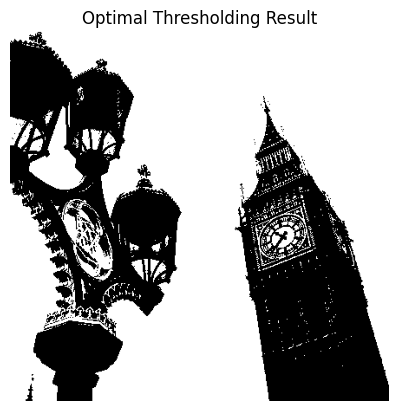

In [11]:
# Apply optimal thresholding
optimal_thresholded_image = optimal_thresholding(grayscale_image.copy())

# Display the thresholded image
plt.imshow(optimal_thresholded_image, cmap='gray')
plt.title('Optimal Thresholding Result')
plt.axis('off')
plt.show()


## Otsu Thresholding

In [6]:
def otsu_thresholding_helper_function(normalized_histogram, outer_th):
    """
    Applies Otsu thresholding to an image.

    Args:
        normalized_histogram: normalized histogram of the image
        outer_th: lower threshold limit for Otsu's method

    Returns:
        Optimal threshold for separating classes.
    """
    weighted_sum = 0
    probability_class1 = normalized_histogram[0]
    global_mean = np.sum(np.arange(len(normalized_histogram)) * normalized_histogram)
    global_variance = np.sum(((np.arange(len(normalized_histogram)) - global_mean) ** 2) * normalized_histogram)
    maximum_variance = 0
    maximum_variance_indices = []

    for k in range(int(outer_th), 255):
        probability_class1 += normalized_histogram[k]
        weighted_sum += k * normalized_histogram[k]
        if probability_class1 * (1 - probability_class1) == 0: 
            continue
        between_class_variance = (((global_mean * probability_class1) - weighted_sum) ** 2) / (probability_class1 * (1 - probability_class1))
        if between_class_variance > maximum_variance:
            maximum_variance = between_class_variance
            maximum_variance_indices = [k]
        elif between_class_variance == maximum_variance:
            maximum_variance_indices.append(k)

    if len(maximum_variance_indices) > 1:
        threshold = np.mean(maximum_variance_indices)
        print('len(maximum_variance_indices) > 1')
    elif len(maximum_variance_indices) == 1:
        threshold = maximum_variance_indices[0]
        print('len(maximum_variance_indices) == 1')
    else:
        print('no maximum between_class_variance')
        return 0
    return threshold

In [7]:
def Normalized_histogram_computation(Image):
    """
    Compute the normalized histogram of a grayscale image.

    Parameters:
    - Image: numpy.ndarray.

    Returns:
    - Histogram: numpy array representing the normalized histogram of the input image.
    """
    Image_Height = Image.shape[0]
    Image_Width = Image.shape[1]
    Histogram = np.zeros([256])

    for x in range(0, Image_Height):
        for y in range(0, Image_Width):
            Histogram[Image[x, y]] += 1

    Histogram /= (Image_Height * Image_Width)
    return Histogram


In [8]:
def otsu_thresholding(image, n_components):
    otsu_img = image.copy()
    thresholds = []
    normalized_histogram = Normalized_histogram_computation(otsu_img)
    thresholds.append(otsu_thresholding_helper_function(normalized_histogram, 1))
    print(0, thresholds[0])
    background_pixels = np.where(otsu_img < thresholds[0])
    otsu_img[background_pixels] = 0
    normalized_histogram = Normalized_histogram_computation(otsu_img)
    normalized_histogram[0] = 0

    for i in range(1, n_components - 1):
        if thresholds[i - 1] == 0:
            break
        thresholds.append(otsu_thresholding_helper_function(normalized_histogram, thresholds[i - 1]))
        print(i, thresholds[i])
        background_pixels = np.where(otsu_img < thresholds[i])
        otsu_img[background_pixels] = 0
        normalized_histogram = Normalized_histogram_computation(otsu_img)
        normalized_histogram[0] = 0

    # Assign colors to the segmented components
    colors = [0, 128, 255]
    for i, th in enumerate(thresholds):
        print(colors[i])
        image[image > th] = colors[i]
    return image


len(maximum_variance_indices) == 1
0 131
len(maximum_variance_indices) == 1
1 254
0
128


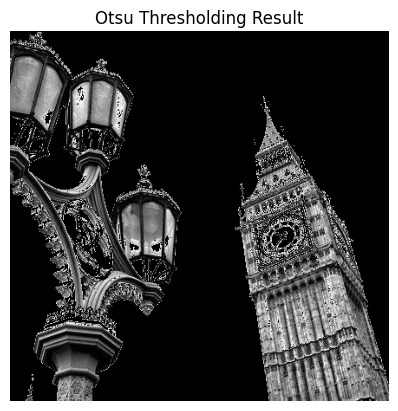

In [12]:
# Apply Otsu thresholding
n_components = 3  # Adjust as needed
otsu_thresholded_image = otsu_thresholding(grayscale_image.copy(), n_components)

# Display the thresholded image
plt.imshow(otsu_thresholded_image, cmap='gray')
plt.title('Otsu Thresholding Result')
plt.axis('off')
plt.show()


## Fit Gaussian on Histogram


In [22]:
def gauss(x: np.ndarray, mu: float, sigma: float):
    """Calculate the Gaussian probability density function."""
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-(x - mu)**2 / (2 * sigma**2))

def norm_gauss(x, mu, sigma, A):
    """Produce a normalized Gaussian distribution."""
    if sigma != 0:
        return A * (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))


In [28]:
def fit_gauss_on_histogram(un_normalized_histogram, n_components):
    ######## Initialization ##########
    gauss_parameters = np.zeros((3, n_components))
    Y = un_normalized_histogram.flatten()  # Use the flattened histogram directly
    bins = np.arange(len(Y))  # Create bin indices for plotting
    
    # Initial values for each component
    for component_number in range(n_components):
        gauss_parameters[0, component_number] = np.argmax(Y)  # Initial mu
        gauss_parameters[1, component_number] = np.std(Y)  # Initial sigma
        gauss_parameters[2, component_number] = 1.0 / n_components  # Initial pi (uniform)

    gamma_vector = np.zeros((n_components, Y.shape[0]))
    
    # EM Algorithm
    num_epochs = 20
    log_likelihoods = []
    
    for epoch in range(num_epochs):
        # E-Step: Compute the responsibilities
        for component_number in range(n_components):
            gamma_vector[component_number] = (
                gauss_parameters[2, component_number] * 
                norm.pdf(bins, gauss_parameters[0, component_number], gauss_parameters[1, component_number])
            )
        
        # Normalize gamma_vector
        gamma_vector /= np.sum(gamma_vector, axis=0)

        # M-Step: Update the parameters
        for component_number in range(n_components):
            # Estimated mu
            gauss_parameters[0, component_number] = np.sum(gamma_vector[component_number] * bins) / np.sum(gamma_vector[component_number])
            # Estimated sigma
            gauss_parameters[1, component_number] = np.sqrt(np.sum(gamma_vector[component_number] * (bins - gauss_parameters[0, component_number])**2) / np.sum(gamma_vector[component_number]))
            # Estimated pi
            gauss_parameters[2, component_number] = np.mean(gamma_vector[component_number])

        # Log likelihood
        log_likelihood = np.sum(np.log(np.sum(gamma_vector, axis=0)))
        log_likelihoods.append(log_likelihood)
    
    # Plotting the results
    plt.figure(figsize=(10, 5))
    plt.bar(bins, Y, width=1, alpha=0.5, label='Histogram')
    
    # Plot each Gaussian component
    x = np.linspace(0, 255, 256)  # Create an x-axis for plotting
    for component_number in range(n_components):
        plt.plot(x, gauss_parameters[2, component_number] * norm.pdf(x, gauss_parameters[0, component_number], gauss_parameters[1, component_number]), 
                 label=f'Component {component_number + 1}')
    
    plt.title('Gaussian Fit on Histogram')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


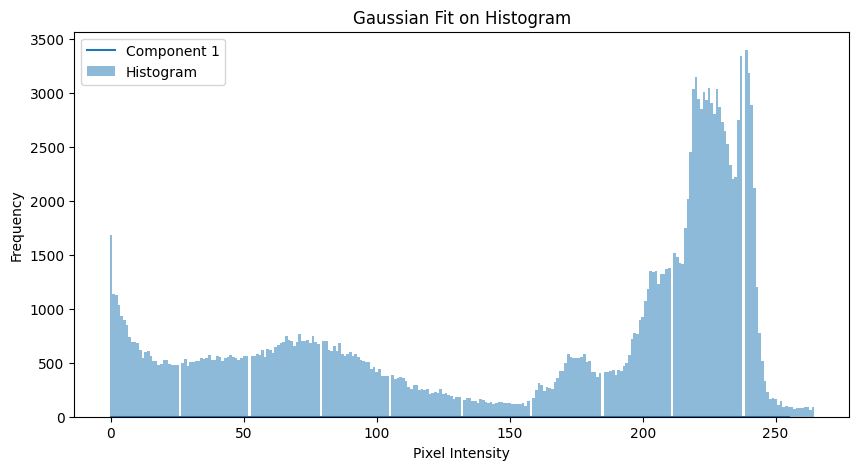

In [29]:
# Load the image
image = cv2.imread('../test_images/elizabeth_tower_london.jpg', 0)  # Ensure this path is correct

# Calculate the histogram
histogram, bins = np.histogram(image.flatten(), bins=265, range=[0, 255])
histogram = histogram.reshape(-1, 1)
fit_gauss_on_histogram(histogram, 1)

In [30]:
arr_of_integers = np.array([1, 2, 4, 5, 3, 3, 2, 4, 5, 4, 2])  # Input array
no_regions = 3  # Number of regions
ration = 0.5  # Ratio for bounds
regions = []  # List to store regions

# Step 1: Find maximum values and their indices
max_val = np.max(arr_of_integers)
max_indices = np.where(arr_of_integers == max_val)[0]

# Step 2: Create regions around the max values
for i in range(no_regions):
    if i < len(max_indices):
        max_index = max_indices[i]
        
        # Define the bounds based on the maximum value and ratio
        left_bound = max(0, max_index - int(max_val * ration))  # Ensure index is not negative
        right_bound = min(len(arr_of_integers) - 1, max_index + int(max_val * ration))  # Ensure index is within bounds

        # Extract the region tuples (index, value)
        sub_range = [(j, arr_of_integers[j]) for j in range(left_bound, right_bound + 1)]
        
        # Append to regions
        regions.append(sub_range)

        # Set the assigned indices to 0 to avoid re-assigning
        for j in range(left_bound, right_bound + 1):
            arr_of_integers[j] = 0

# Step 3: Assign unassigned indices to the nearest region
for idx in range(len(arr_of_integers)):
    if arr_of_integers[idx] != 0:
        # Find the closest region
        closest_region_index = np.argmin([abs(idx - max_indices[i]) for i in range(len(max_indices))])
        regions[closest_region_index].append((idx, arr_of_integers[idx]))

print(regions)

[[(1, 2), (2, 4), (3, 5), (4, 3), (5, 3), (0, 1)], [(6, 2), (7, 4), (8, 5), (9, 4), (10, 2)]]


creating colored rectangles centered at the maximum values of an array and plot them on a histogram.


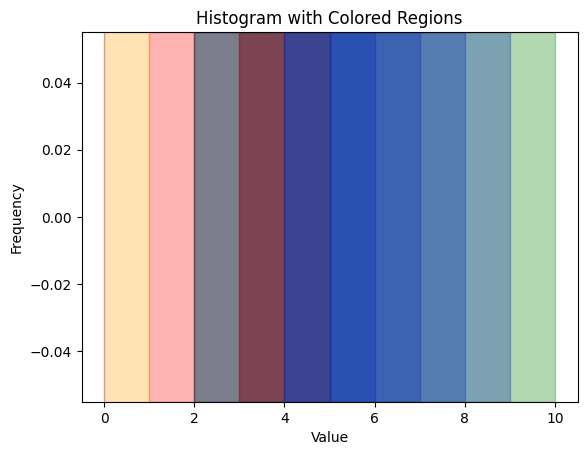

In [132]:
# Original array
arr_of_integers = np.array(
    [1, 2, 4, 5, 3, 3, 2, 4, 5, 4, 2]
)

# Goal: Create rectangles, centered at max values like 5,5, and bounded from right and left till int(max/2)
no_regions = 5
ratio = 0.5
regions = []  # Initialize an empty list to store subarrays

for i in range(no_regions):
    # Find the maximum value in the array
    max_val = np.max(arr_of_integers)
    # Find the indices of the maximum value
    max_indices = np.where(arr_of_integers == max_val)[0]
    # Define the bounds
    left_bound = max(0, int(max_val * ratio))
    right_bound = min(len(arr_of_integers), int(max_val * ratio) + 1)

    sub_range = []
    pointer = max_val
    indx = max_indices[0]

    # Add elements to the sub_range towards the left bound
    while (indx >= 0 and pointer >= left_bound):
        sub_range.append((indx, pointer))
        indx -= 1
        if indx >= 0:
            pointer = arr_of_integers[indx]

    # Add elements to the sub_range towards the right bound
    if max_indices[0] < len(arr_of_integers) - 1:
        indx = max_indices[0] + 1
        pointer = arr_of_integers[indx]
        while (indx < len(arr_of_integers) and pointer >= right_bound):
            sub_range.append((indx, pointer))
            indx += 1
            if indx < len(arr_of_integers):
                pointer = arr_of_integers[indx]

    # Sort sub_range based on indices
    sub_range.sort()

    regions.append(sub_range)  # Append the sub_range to regions

    arr_of_integers[sub_range] = 0  # Set the elements in sub_range to 0

# Assign remaining indices to the nearest region
remaining_indices = np.where(arr_of_integers != 0)[0]
for index in remaining_indices:
    min_distance = float("inf")
    nearest_region = None
    for j, region in enumerate(regions):
        region_indices = [x[0] for x in region]
        if region_indices:
            region_index = region_indices[0]
            distance = abs(index - region_index)
            if distance < min_distance:
                min_distance = distance
                nearest_region = j
    if nearest_region is not None:
        regions[nearest_region].append((index, arr_of_integers[index]))
        arr_of_integers[index] = 0

# Sort each region based on indices
for region in regions:
    region.sort()

# Plot the original array as a histogram
plt.hist(arr_of_integers, bins=np.arange(0, np.max(arr_of_integers) + 1), color='gray', alpha=0.5)

# Define colors for regions
colors = ['red', 'blue', 'green', 'orange', 'purple']

# Plot each region with a different color
for i, region in enumerate(regions):
    for start, end in region:
        plt.axvspan(start, end, color=colors[i], alpha=0.3)

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram with Colored Regions')
plt.show()


In [31]:
arr_of_integers = np.array(
    [1, 2, 4, 5, 3, 3, 2, 4, 5, 4, 2]
)

no_regions = 5
ratio = 0.5
regions = [None] * no_regions

for i in range(no_regions):
    max_val = np.max(arr_of_integers)
    max_indices = np.where(arr_of_integers == max_val)[0]
    left_bound = int(max_val * ratio)
    right_bound = int(max_val * ratio)
    sub_range = []; pointer = max_val; indx = max_indices[0]

    while (indx > 0 and pointer >= left_bound):
        sub_range.append((indx,pointer))
        indx -=1
        pointer = arr_of_integers[indx]
        
    if (max_indices[0]+1 < len(arr_of_integers)):
        indx = max_indices[0]+1
        pointer = arr_of_integers[indx]

    while (indx < len(arr_of_integers) and pointer >= right_bound):
        sub_range.append((indx, pointer))
        if indx + 1 < len(arr_of_integers):  # Add a condition to check if the index is within the array bounds
            indx += 1
            pointer = arr_of_integers[indx]
        else:
            break  # Break the loop if the index is out of bounds
        
    sub_range.sort(key=lambda x: x[0])
    regions[i] = sub_range
    arr_of_integers[[x[0] for x in sub_range]] = 0

remaining_indices = np.where(arr_of_integers != 0)[0]
for index in remaining_indices:
    min_distance = float("inf")
    nearest_region = None
    for j in range(no_regions):
        region_indices = [x[0] for x in regions[j]]
        region_index = region_indices[0]
        distance = abs(index - region_index)
        if distance < min_distance:
            min_distance = distance
            nearest_region = j
    regions[nearest_region].append((index, arr_of_integers[index]))
    arr_of_integers[index] = 0

# Sort the regions based on the first index of each region
regions.sort(key=lambda x: x[0][0])

print(regions)


[[(1, 2), (2, 4), (3, 5), (4, 3), (5, 3), (6, 2), (7, 4), (8, 5), (9, 4), (10, 2), (0, 1)], [(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0)], [(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0)], [(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0)], [(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0)]]


1.0
0.0054195429369356


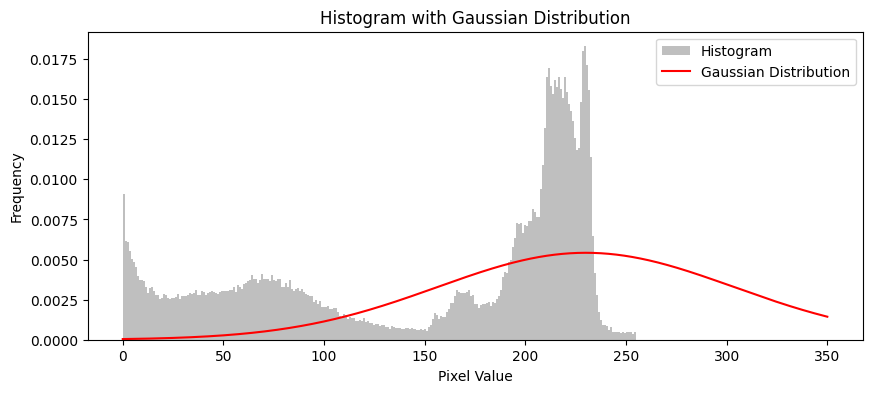

In [33]:
def gauss(x: np.ndarray, mu: float, sigma: float):
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Load the image in grayscale mode
image = cv2.imread('../test_images/elizabeth_tower_london.jpg', 0)

# Calculate the histogram
histogram, bins = np.histogram(image.flatten(), bins=256, range=[0, 255])
# Convert histogram to float64 and normalize it
histogram = histogram.astype(np.float64)
histogram /= histogram.max()
print(histogram.max()) # 1723
# Calculate mean and standard deviation of the histogram
mean_value =  np.argmax(histogram)

std_dev = np.std(bins[:-1])

fig = plt.figure(figsize=(10, 4))

# Plot the histogram
plt.hist(image.flatten(), bins=256, range=[0, 255], color='gray', alpha=0.5, label='Histogram', density=True)

# Plot the Gaussian distribution
x_values = np.linspace(0, 350, 1000)
gaussian_values = gauss(x_values, mean_value, std_dev) 
print(gaussian_values.max())
# gaussian_values *= histogram.max()/gaussian_values.max() # Scale to fit the histogram
plt.plot(x_values, gaussian_values, color='red', label='Gaussian Distribution')

plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.title('Histogram with Gaussian Distribution')
plt.legend()
plt.show()


Thresholds:  [214.10118978  17.31916803  86.52277705]


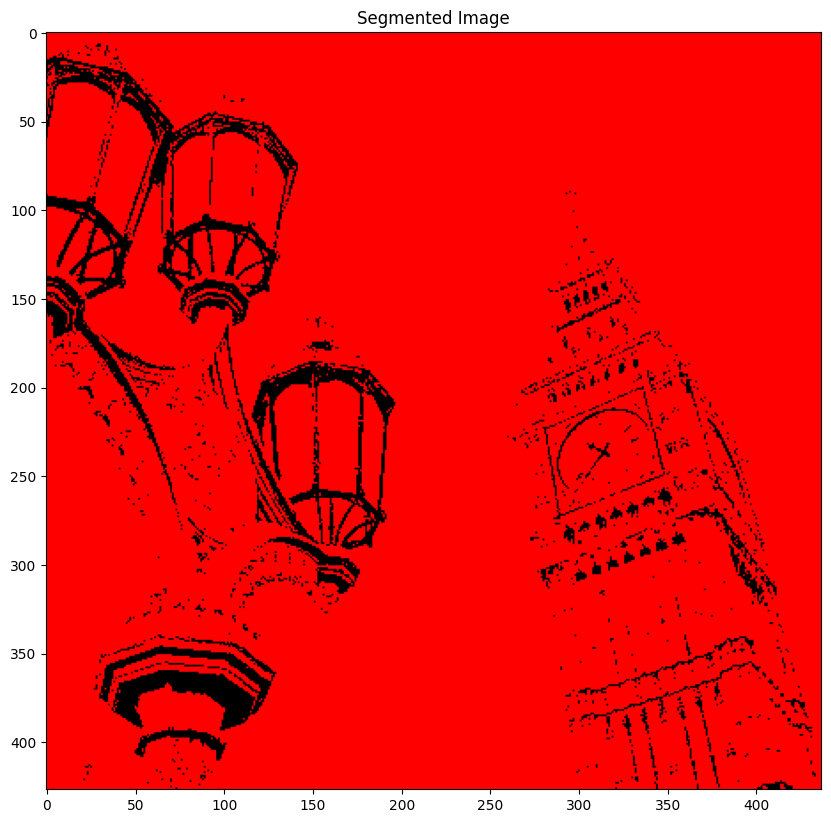

In [34]:
# Load the image in grayscale mode
image = cv2.imread('../test_images/elizabeth_tower_london.jpg', 0)

# Calculate the histogram
histogram, bins = np.histogram(image.flatten(), bins=256, range=[0,256])

# Normalize the histogram
histogram = histogram.astype(np.float64)
histogram /= histogram.sum()

# Prepare data for GMM
histogram = (histogram * 10000).astype(int)  # Multiply by large number before converting to int
bins = bins[:-1].reshape(-1, 1)

# Fit a GMM to the histogram
n_components = 3  # Number of Gaussian components
gmm = GaussianMixture(n_components=n_components)
gmm.fit(np.repeat(bins, histogram, axis=0))

# Get the fitted parameters
weights = gmm.weights_
means = gmm.means_
covariances = gmm.covariances_

# Print the thresholds (means of the Gaussians)
print("Thresholds: ", means.flatten())

# Segment the image based on the thresholds
segmented_image = np.zeros_like(image, dtype=np.uint8)
segmented_image_color = cv2.cvtColor(segmented_image, cv2.COLOR_GRAY2BGR)  # Convert to color image
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)]  # Define colors for each segment
for i in range(1, n_components):
    segmented_image_color[image > means[i-1]] = colors[i]

# Display the segmented image using plt
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(segmented_image_color, cv2.COLOR_BGR2RGB))  # Convert color from BGR to RGB for plt
plt.title('Segmented Image')
plt.show()


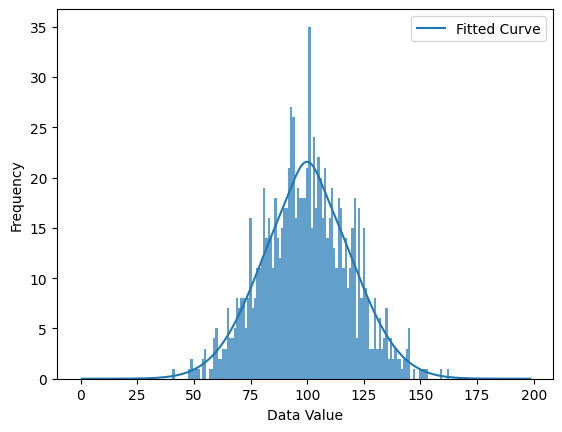

In [35]:
# Sample histogram data (replace with your actual data)
x = np.arange(0, 200, 1)  # Assuming data ranges from 0 to 199

y = np.random.normal(loc=100, scale=20, size=1000)  # Simulates data with a single Gaussian
hist, bins = np.histogram(y, bins=x)  # Create the histogram
# Calculate bin centers
x = bins[:-1] + (bins[1] - bins[0]) / 2

# ... rest of the code remains the same
# Define the function for a single Gaussian distribution
def single_gaussian(x, mean, amp, std):
  return amp * np.exp(-(x - mean)**2 / (2*std**2))

# Define the function for a sum of two Gaussians
def double_gaussian(x, mean1, amp1, std1, mean2, amp2, std2):
  return single_gaussian(x, mean1, amp1, std1) + single_gaussian(x, mean2, amp2, std2)

# Initial guesses for the parameters of the Gaussians (adjust based on your data)
p0 = [90, 0.5, 15, 110, 0.3, 10] 

# Perform the fit
popt, pcov = curve_fit(double_gaussian, x, hist, p0=p0)

# Extract fitted parameters
mean1, amp1, std1, mean2, amp2, std2 = popt

# Plot the histogram and the fitted Gaussians
plt.bar(bins[:-1], hist, width=bins[1] - bins[0], alpha=0.7)
plt.plot(x, double_gaussian(x, mean1, amp1, std1, mean2, amp2, std2), label='Fitted Curve')
plt.xlabel('Data Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [24]:
for i in range(1):
    print(i)

0


In [9]:
x = norm.pdf([1,2,3,4],2,3)
y = norm_gauss(np.array([1,2,3,4]),2,3)
x,y

(array([0.12579441, 0.13298076, 0.12579441, 0.10648267]),
 array([0.12579441, 0.13298076, 0.12579441, 0.10648267]))

In [14]:
X_dists = np.zeros((3,))
len(X_dists), X_dists.ndim

(3, 1)

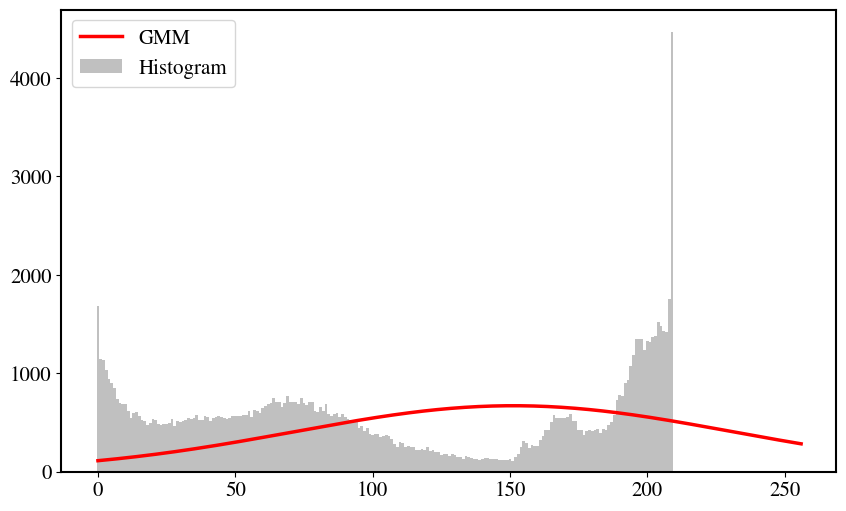

In [40]:
# Set matplotlib parameters for cosmetics
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams.update({'font.size': 15, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

# Load image
image = cv2.imread('', 0)

# Compute histogram
histogram, bins = np.histogram(image.flatten(), bins=210, range=[0, 210])
x = histogram
x = x.reshape(-1, 1) #/ (image.shape[0] * image.shape[1])  # Normalize histogram

# Reshape the data for GMM
data = image.flatten()
data = data.reshape(-1, 1)

# Fit a GMM
gmm = GMM(n_components=1)
gmm.fit(data)

# Get the fitted parameters
weights = gmm.weights_
means = gmm.means_
covariances = gmm.covariances_

# Create a grid for plot
grid = np.linspace(0, 256, 256)

# Compute the Gaussian function for each component
gmm_pdf = np.zeros_like(grid)
for i in range(gmm.n_components):
    gmm_pdf += weights[i] * norm.pdf(grid, means[i, 0], np.sqrt(covariances[i, 0]))

# Normalize the GMM PDF to make it comparable with the histogram
gmm_pdf = gmm_pdf * np.sum(histogram) / np.sum(gmm_pdf)

# Plot the histogram and the fitted GMM
plt.figure(figsize=(10, 6))
plt.bar(bins[:-1], histogram, width=1, color='silver', label='Histogram')
plt.plot(grid, gmm_pdf, color='red', linewidth=2.5, label='GMM')
plt.legend()
plt.show()


3


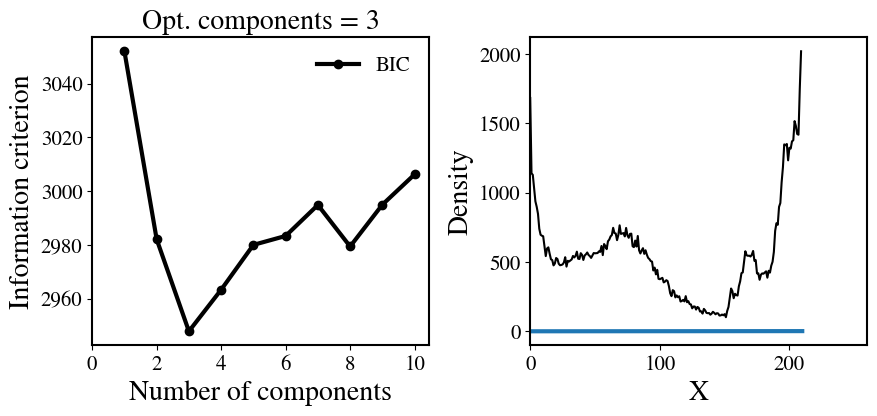

In [48]:
# import libraries (some are for cosmetics)

mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams.update({'font.size': 15, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})


# create the data 
image= cv2.imread('../test_images/elizabeth_tower_london.jpg',0)
x, bins = np.histogram(image.flatten(), bins=256, range=[0,256])
x = x.reshape(-1, 1)[:210] #/ (image.shape[0] * image.shape[1])  # Normalize histogram

# first of all, let's confirm the optimal number of components
bics = []
min_bic = 0
counter=1
for i in range (10): # test the AIC/BIC metric between 1 and 10 components
  gmm = GMM(n_components = counter, max_iter=1000, random_state=0, covariance_type = 'full')
  labels = gmm.fit(x).predict(x)
  bic = gmm.bic(x)
  bics.append(bic)
  if bic < min_bic or min_bic == 0:
    min_bic = bic
    opt_bic = counter
  counter = counter + 1


# plot the evolution of BIC/AIC with the number of components
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1,2,1)
# Plot 1
plt.plot(np.arange(1,11), bics, 'o-', lw=3, c='black', label='BIC')
plt.legend(frameon=False, fontsize=15)
plt.xlabel('Number of components', fontsize=20)
plt.ylabel('Information criterion', fontsize=20)
plt.xticks(np.arange(0,11, 2))
plt.title('Opt. components = '+str(opt_bic), fontsize=20)


# Since the optimal value is n=2 according to both BIC and AIC, let's write down:
n_optimal = opt_bic

# create GMM model object
print(n_optimal)
gmm = GMM(n_components = 1, max_iter=1000, random_state=10, covariance_type = 'full')

# find useful parameters
data = image.flatten()
data = data.reshape(-1, 1)
mean = gmm.fit(data).means_  
covs  = gmm.fit(data).covariances_
weights = gmm.fit(data).weights_

# create necessary things to plot
# Adjust the range of x_axis and x_lim according to your data
x_min = np.min(x)
x_max = np.max(x)
x_axis = np.arange(0, 210, 0.1)
y_axis0 = 400*norm.pdf(x_axis, float(mean[0][0]), np.sqrt(float(covs[0][0][0])))*weights[0] # 1st gaussian
# y_axis1 = norm.pdf(x_axis, float(mean[1][0]), np.sqrt(float(covs[1][0][0])))*weights[1] # 2nd gaussian

ax = fig.add_subplot(1,2,2)
# Plot 2
plt.plot(x,  color='black')  # it's only one column, while x ranges from 0 to 255
plt.plot(x_axis, y_axis0, lw=3, c='C0')
# plt.plot(x_axis, y_axis1, lw=3, c='C1')
# plt.plot(x_axis, y_axis0+y_axis1, lw=3, c='C2', ls='dashed')
plt.xlim(0, 260)
#plt.ylim(0.0, 2.0)
plt.xlabel(r"X", fontsize=20)
plt.ylabel(r"Density", fontsize=20)

plt.subplots_adjust(wspace=0.3)
plt.show()
plt.close('all')


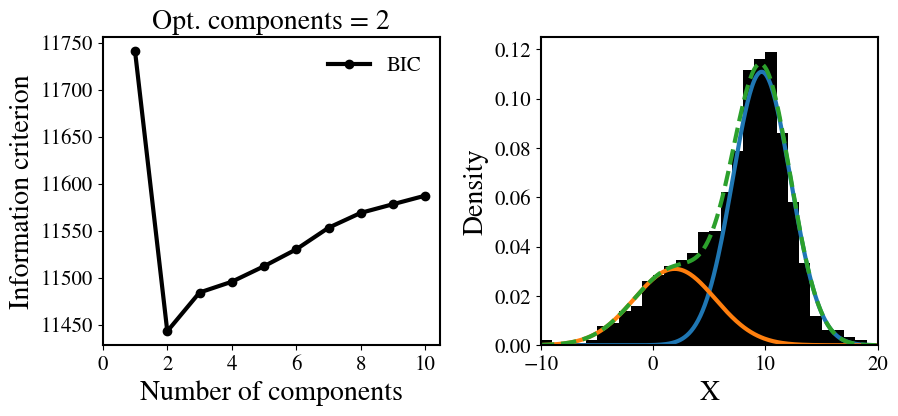

In [49]:
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams.update({'font.size': 15, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})


# create the data as in @Meng's answer
x = np.concatenate((np.random.normal(5, 5, 1000), np.random.normal(10, 2, 1000)))
x = x.reshape(-1, 1) # shape (2000,1)

# modify the code to plot new x
# first of all, let's confirm the optimal number of components
bics = []
min_bic = 0
counter=1
for i in range (10): # test the AIC/BIC metric between 1 and 10 components
  gmm = GMM(n_components = counter, max_iter=1000, random_state=0, covariance_type = 'full')
  labels = gmm.fit(x).predict(x)
  bic = gmm.bic(x)
  bics.append(bic)
  if bic < min_bic or min_bic == 0:
    min_bic = bic
    opt_bic = counter
  counter = counter + 1


# plot the evolution of BIC/AIC with the number of components
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1,2,1)
# Plot 1
plt.plot(np.arange(1,11), bics, 'o-', lw=3, c='black', label='BIC')
plt.legend(frameon=False, fontsize=15)
plt.xlabel('Number of components', fontsize=20)
plt.ylabel('Information criterion', fontsize=20)
plt.xticks(np.arange(0,11, 2))
plt.title('Opt. components = '+str(opt_bic), fontsize=20)


# Since the optimal value is n=2 according to both BIC and AIC, let's write down:
n_optimal = opt_bic

# create GMM model object
gmm = GMM(n_components = n_optimal, max_iter=1000, random_state=10, covariance_type = 'full')

# find useful parameters
mean = gmm.fit(x).means_  
covs  = gmm.fit(x).covariances_
weights = gmm.fit(x).weights_

# create necessary things to plot
x_axis = np.arange(-20, 30, 0.1)
y_axis0 = norm.pdf(x_axis, float(mean[0][0]), np.sqrt(float(covs[0][0][0])))*weights[0] # 1st gaussian
y_axis1 = norm.pdf(x_axis, float(mean[1][0]), np.sqrt(float(covs[1][0][0])))*weights[1] # 2nd gaussian

ax = fig.add_subplot(1,2,2)
# Plot 2
plt.hist(x, density=True, color='black', bins=np.arange(-10, 100, 1))
plt.plot(x_axis, y_axis0, lw=3, c='C0')
plt.plot(x_axis, y_axis1, lw=3, c='C1')
plt.plot(x_axis, y_axis0+y_axis1, lw=3, c='C2', ls='dashed')
plt.xlim(-10, 20)
#plt.ylim(0.0, 2.0)
plt.xlabel(r"X", fontsize=20)
plt.ylabel(r"Density", fontsize=20)

plt.subplots_adjust(wspace=0.3)
plt.show()
plt.close('all')

            params     sigma
mu1       1.014589  0.005273
sigma1    0.203826  0.004067
A1      230.654585  3.667409
mu2       1.635225  0.022423
sigma2    0.282690  0.019070
A2       72.621856  2.148459


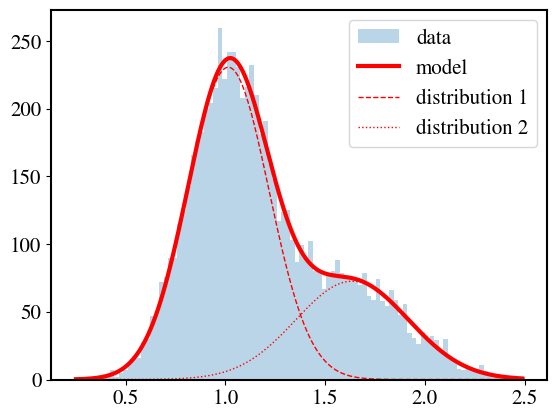

In [50]:
#data generation
np.random.seed(123)
data=np.concatenate((np.random.normal(1, .2, 5000), np.random.normal(1.6, .3, 2500)))

y,x,_=plt.hist(data, 100, alpha=.3, label='data')
x=(x[1:]+x[:-1])/2 # for len(x)==len(y)

#x, y inputs can be lists or 1D numpy arrays

def gauss(x, mu, sigma, A):
    return A*np.exp(-((x-mu)**2/2)/sigma**2)

def bimodal(x, mu1, sigma1, A1, mu2, sigma2, A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

expected = (1, .2, 250, 2, .2, 125)
params, cov = curve_fit(bimodal, x, y, expected)
sigma=np.sqrt(np.diag(cov))
x_fit = np.linspace(x.min(), x.max(), 500)
#plot combined...
plt.plot(x_fit, bimodal(x_fit, *params), color='red', lw=3, label='model')
#...and individual Gauss curves
plt.plot(x_fit, gauss(x_fit, *params[:3]), color='red', lw=1, ls="--", label='distribution 1')
plt.plot(x_fit, gauss(x_fit, *params[3:]), color='red', lw=1, ls=":", label='distribution 2')
#and the original data points if no histogram has been created before
#plt.scatter(x, y, marker="X", color="black", label="original data")
plt.legend()
print(pd.DataFrame(data={'params': params, 'sigma': sigma}, index=bimodal.__code__.co_varnames[1:]))
plt.show()